In [235]:
import os
from datetime import datetime
from kan import *
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

In [236]:
# class Formula:
#     @staticmethod
#     def evaluate(x):
#         # Define your formula here - only place to change!
#         return torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2) 
    
#     @staticmethod
#     def get_string():
#         # Return string representation of the formula
#         return "exp(sin(pi*x)+y^2)"
    
#     @staticmethod
#     def get_filename():
#         # Return filename-friendly version of formula
#         return "exp_sin_pix+y2"
        
#     @staticmethod
#     def calculate_numpy(x, y):
#         # Numpy version for plotting
#         return np.exp(np.sin(np.pi*x) + y**2)

In [237]:
# class Formula:
#     @staticmethod
#     def evaluate(x):
#         # Define your formula here - only place to change!
#         return 3*x[:,[0]] + 5*x[:,[1]] 
    
#     @staticmethod
#     def get_string():
#         # Return string representation of the formula
#         return "3*x+5*y"
    
#     @staticmethod
#     def get_filename():
#         # Return filename-friendly version of formula
#         return "3x+5y"
        
#     @staticmethod
#     def calculate_numpy(x, y):
#         # Numpy version for plotting
#         return 3*x + 5*y

In [238]:
class Formula:
    @staticmethod
    def evaluate(x):
        # Define your formula here - only place to change!
        return x[:,[0]]**2 + 2*x[:,[1]] 
    
    @staticmethod
    def get_string():
        # Return string representation of the formula
        return "x**2+2*y"
    
    @staticmethod
    def get_filename():
        # Return filename-friendly version of formula
        return "x2+2y"
        
    @staticmethod
    def calculate_numpy(x, y):
        # Numpy version for plotting
        return x**2 + 2*y

In [239]:
def plot_training_history(history):
    """Plot training history including loss and regularization"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(121)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['test_loss'], label='Test')
    plt.title('Loss History')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history['reg'], label='Regularization')
    plt.title('Regularization Term')
    plt.xlabel('Step')
    plt.ylabel('Reg Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [240]:
def compare_functions(model, x_range=(-5, 5), n_points=50):
    """Compare original and predicted formulas in a single plot with metrics"""
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = x  # Use same range for y

    plt.figure(figsize=(8, 6))
    
    original = f"f(x,y) = {Formula.get_string()}"
    predicted = str(ex_round(model.symbolic_formula()[0][0], 4))
    
    original_values = Formula.calculate_numpy(x, y)
    plt.plot(x, original_values, 'b-', label=f'Original: {original}', linewidth=2)
    
    xy_points = torch.tensor(np.column_stack((x, y)), dtype=torch.float64).to(model.device)
    with torch.no_grad():
        predicted_values = model(xy_points).cpu().numpy()
    plt.plot(x, predicted_values, 'r--', label=f'Predicted: {predicted}', linewidth=2)
    
    r2 = r2_score(original_values, predicted_values)
    mse = mean_squared_error(original_values, predicted_values)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Original vs Predicted Formula')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFormula Comparison:")
    print(f"Original: {original}")
    print(f"Predicted: {predicted}")
    print(f"\nMetrics:")
    print(f"R² Score: {r2:.6f}")
    print(f"MSE: {mse:.6f}")
    
    return r2, mse

In [241]:
# Main execution
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

Using device: cuda
checkpoint directory created: ./model
saving model version 0.0


In [242]:
# Create dataset using the centralized formula
dataset = create_dataset(Formula.evaluate, n_var=2, device=device)

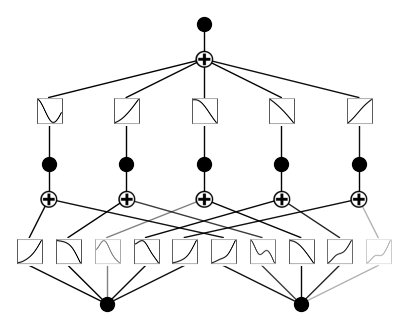

In [243]:
model(dataset['train_input'])
model.plot()

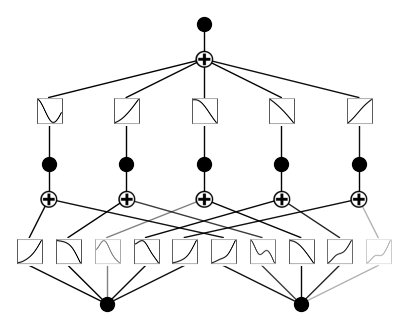

In [244]:
# Initial state

model(dataset['train_input'])
model.plot()

# fig = model.plot()
# fig.savefig('/home/user/WindowsShare/06. Programming/develop/JM_KAN/coef_tests/exp_sin_pix+y2/20241203_191034/model_structure_init.png') 

| train_loss: 9.18e-03 | test_loss: 1.03e-02 | reg: 5.94e+00 | : 100%|█| 100/100 [00:51<00:00,  1.94


saving model version 0.1


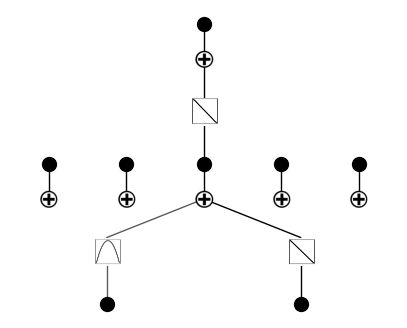

In [245]:
# Initial training
history = model.fit(dataset, opt="LBFGS", steps=100, lamb=0.001)
model.plot()

saving model version 0.2


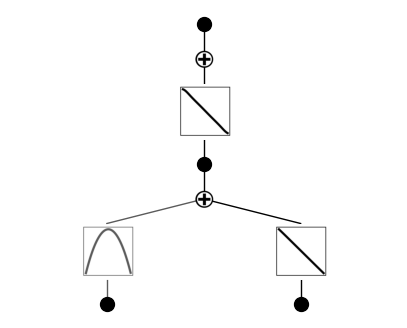

In [246]:
model = model.prune()
model.plot()

In [247]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs'] 

# lib = ['x']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.9999929586022813, c=2
fixing (0,1,0) with x, r2=0.9999967592074707, c=1
fixing (1,0,0) with x, r2=0.9999308124563832, c=1
saving model version 0.3


In [248]:
formula = str(ex_round(model.symbolic_formula()[0][0], 4))
print("\nPredicted formula:", formula)


Predicted formula: 0.995*x_1**2 + 1.9978*x_2 - 0.1528


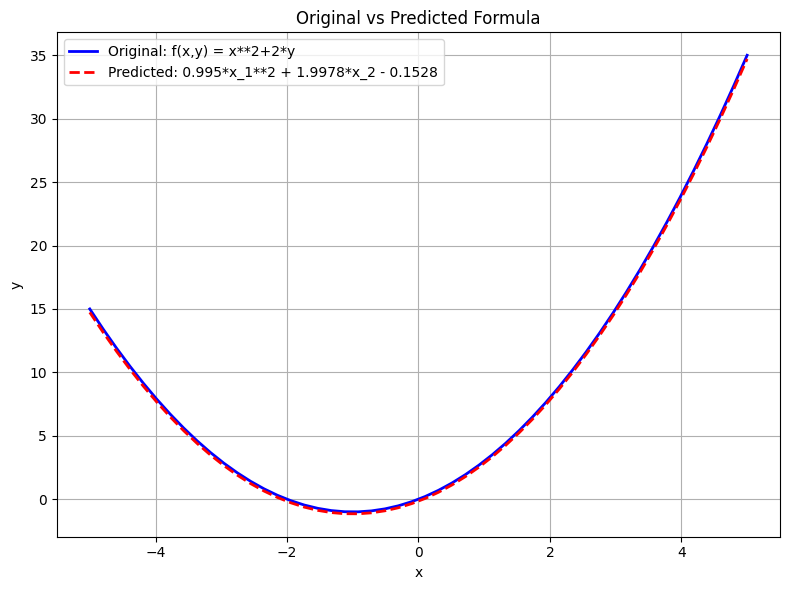


Formula Comparison:
Original: f(x,y) = x**2+2*y
Predicted: 0.995*x_1**2 + 1.9978*x_2 - 0.1528

Metrics:
R² Score: 0.999576
MSE: 0.040209


In [249]:
r2, mse = compare_functions(model)

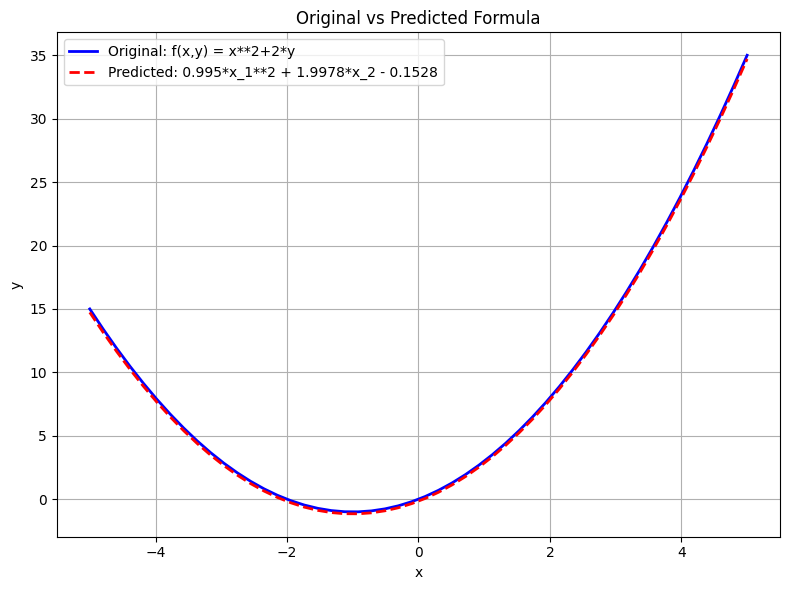


Formula Comparison:
Original: f(x,y) = x**2+2*y
Predicted: 0.995*x_1**2 + 1.9978*x_2 - 0.1528

Metrics:
R² Score: 0.999576
MSE: 0.040209
Plots and log saved in directory:
/home/user/WindowsShare/06. Programming/develop/JM_KAN/coef_tests/x2+2y/20241203_212528

Files saved:
- formula_comparison.png
- loss_history.png
- regularization.png
- log.txt


In [250]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
base_dir = '/home/user/WindowsShare/06. Programming/develop/JM_KAN/coef_tests'
formula_dir = os.path.join(base_dir, Formula.get_filename())
save_dir = os.path.join(formula_dir, timestamp)
os.makedirs(save_dir, exist_ok=True)

log_filename = os.path.join(save_dir, 'log.txt')

# Save formula comparison plot
plt.figure(figsize=(8, 6))
predicted = str(ex_round(model.symbolic_formula()[0][0], 4))

x = np.linspace(-1, 1, 50)
y = x
original_values = Formula.calculate_numpy(x, y)
plt.plot(x, original_values, 'b-', label=f'Original: {Formula.get_string()}', linewidth=2)

xy_points = torch.tensor(np.column_stack((x, y)), dtype=torch.float64).to(model.device)
with torch.no_grad():
    predicted_values = model(xy_points).cpu().numpy()
plt.plot(x, predicted_values, 'r--', label=f'Predicted: {predicted}', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Original vs Predicted Formula')
plt.legend()
plt.grid(True)
plt.tight_layout()

comparison_filename = os.path.join(save_dir, 'formula_comparison.png')
plt.savefig(comparison_filename, bbox_inches='tight')
plt.close()

# Save loss history plot
plt.figure(figsize=(8, 6))
plt.plot(history['train_loss'], label='Train')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss History')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()

loss_filename = os.path.join(save_dir, 'loss_history.png')
plt.savefig(loss_filename)
plt.close()

# Save regularization plot
plt.figure(figsize=(8, 6))
plt.plot(history['reg'], label='Regularization', color='green')
plt.title('Regularization Term')
plt.xlabel('Step')
plt.ylabel('Reg Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

reg_filename = os.path.join(save_dir, 'regularization.png')
plt.savefig(reg_filename)
plt.close()

# R^2, MSE 
r2, mse = compare_functions(model)
with open(log_filename, 'w') as log_file:
    log_file.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    log_file.write(f"Base Directory: {base_dir}\n")
    log_file.write(f"Formula Directory: {formula_dir}\n")
    log_file.write(f"Save Directory: {save_dir}\n")
    log_file.write("\nResults:\n")
    log_file.write(f"R^2 Score: {r2:.4f}\n")
    log_file.write(f"MSE: {mse:.4f}\n")
    log_file.write("-" * 50 + "\n")

print(f"Plots and log saved in directory:\n{save_dir}")
print(f"\nFiles saved:")
print(f"- formula_comparison.png")
print(f"- loss_history.png")
print(f"- regularization.png")
print(f"- log.txt")